In [1]:
%pylab inline
import pandas as pd
import time
#import numpy as np
import pickle
import joblib
import copy as cp
from joblib import Parallel, delayed
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
from sklearn import linear_model as lm
import math as math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from ggplot import *
from sklearn.linear_model import SGDRegressor
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_dd
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier

plt.style.use('seaborn-white')
pandas.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.cm as cm
import operator as o
import itertools
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'whitesmoke'})

In [3]:
# Load frames

with open("pickles/preppedBaseFrames2.pkl",'rb') as f: 
    allSamples2, hadmsList, currStates, nextStates, actions, rewards = pickle.load(f)

allSamples = {}
for i in range(len(allSamples2)):
    h = allSamples2[i]['hadm']
    allSamples[h] = allSamples2[i]
    
feats = ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Weight', 
         'Heart Rate', 'Respiratory Rate','$O_2$ saturation pulseoxymetry', 'NI Blood Pressure (Mean)', 
        '$O_2$ Flow', 'Inspired $O_2$ Fraction', 'Arterial $CO_2$ Pressure', 'Arterial pH', 'Arterial $O_2$ pressure', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
        'Tidal Volume', 'PEEP set', 'Creatinine', 'Hematocrit', 'Blood Urea Nitrogen (BUN)',
        'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Dexmedetomidine (Precedex)', 
        'Morphine Sulfate','Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)',
        'Duration', 'Intubations']

In [4]:
currStates = np.concatenate(currStates)
nextStates = np.concatenate(nextStates)

scaler = StandardScaler() 
scaler.fit(currStates)
currStatesScaled = scaler.transform(currStates)
nextStatesScaled = scaler.transform(nextStates)

hadms = unique(hadmsList)

In [5]:
# Get vent actions; Reset sedative actions using scaled/normalized dosages:

ventActions = np.transpose(actions)[0]

allsums = ([sum([0.2, 0.5, 0.1, 0.2, 0.1, 0.1, 1, 1] * np.transpose((np.transpose(currStatesScaled)[24:32]))[i]) 
            for i in range(len(currStates))])

bins = np.array([-1000.0, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1000.0])
inds = np.digitize(allsums, bins)
#for n in range(179): print bins[inds[n]-1], "<=", allsums[n], "<", bins[inds[n]] 

sedActions = inds - 1
print np.unique(sedActions - 1, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([71403, 98036, 35816, 17703, 10632, 12179, 18097]))


In [6]:
# Patient hadm changepoint

changepoints = zeros(len(hadmsList))
for i in range(1,len(hadmsList)):
    if hadmsList[i] != hadmsList[i-1]:
        changepoints[i] = 1
st = 0
for ed in np.concatenate(np.where(changepoints!=0))[0:10]:
    sums = ([sum([0.2, 0.5, 0.1, 0.2, 0.1, 0.1, 1, 1] * np.transpose((np.transpose(currStatesScaled)[24:32]))[i]) 
             for i in range(st,ed)])
    st = ed
    
print np.concatenate(np.where(changepoints!=0))[0:10]

[ 179  366  460  507  877  989 1219 1249 1278 1311]


In [7]:
# Split train and test sets

trainPts = hadms[:1500]
testPts = hadms[1500:]
breakpoint = np.concatenate(np.where(changepoints!=0))[1500]
trainSet = range(0,breakpoint)
testSet = range(breakpoint,len(hadmsList))

In [8]:
# Fake counter examples with -ve rewards for extubation in the first 5 hours

counterStates = []
counterNext = []
for h in trainPts:
    for s in range(len(allSamples[h]['currStates'])):
        dur =  np.concatenate(allSamples[h]['currStates'][s])[32]
        vent =  (allSamples[h]['actions'][s])[0]
        if dur > 0 and dur <= 6 and vent == 1:
            counterStates.append(allSamples[h]['currStates'][s])
            counterNext.append(allSamples[h]['nextStates'][s])
counterStates = scaler.transform(np.concatenate([counterStates[i] for i in range(len(counterStates))]))
counterNext = scaler.transform(np.concatenate([counterNext[i] for i in range(len(counterStates))]))
counterRewards = np.transpose(np.ones((len(counterStates),1)) *-1.5)
counterActions = np.zeros(len(counterStates))
counterSamples = np.hstack([counterStates, np.zeros((len(counterStates),1))])

In [9]:
def ttSamples(tset, actionType, counter=True):
    
    setStates = [currStatesScaled[i] for i in tset]
    setNextstates = [nextStatesScaled[i]for i in tset]
    if actionType == 'sed':
        setActions = [sedActions[i] for i in tset]
    elif actionType == 'vent':
        setActions = [ventActions[i] for i in tset]
    setRewards = [rewards[i] for i in tset]
    
    setSamples = np.hstack([setStates, np.transpose([setActions])])
    
    if ((actionType=='vent') and (counter==True)):
        setSamples = np.vstack([setSamples, counterSamples])
        setStates = np.vstack([setStates, counterStates])
        setNextstates = np.vstack([setNextstates, counterNext])
        setActions = (np.hstack([setActions, counterActions]))     
        setRewards = np.concatenate(np.hstack([[setRewards], counterRewards]))

    return setSamples, setStates, setNextstates, setActions, setRewards

trainSamples, trainStates, trainNextstates, trainActions, trainRewards = ttSamples(trainSet, 'vent', True)
testSamples, testStates, testNextstates, testActions, testRewards = ttSamples(testSet, 'vent', False)

---------------------

In [10]:
def runFQI(classifier, features, gamma=0.9, batchSize=60000, iterations=100):
    
    ventoff = list(np.concatenate(np.where([ventActions[i] == 0 for i in trainSet])))
    trainSize = len(trainSamples)
    indices = (np.hstack([range(trainSize), ventoff, ventoff, ventoff, ventoff, ventoff]))
    possibleActions = unique(ventActions)
    print 'Initialization'
    #batch = unique(random.choice(indices, batchSize, replace=False)).astype(int)
    batch = indices
    if classifier =='NN':
        Qest = fitNN([np.transpose([trainSamples[s][i] for i in features]) for s in batch], ([trainRewards[s] for s in batch]))
    elif classifier =='Tree':
        Qest = fitTree([np.transpose([trainSamples[s][i] for i in features]) for s in batch], ([trainRewards[s] for s in batch]))
    Q = np.zeros((len(possibleActions), trainSize))
    #Q = 0.1 * np.random.randn(len(possibleActions), trainSize)
    Qdist = []

    print 'Q-iteration'
    iter = 0 
    while iter < iterations:
        batch = random.choice(indices, batchSize, replace=False).astype(int)     
        S = {}
        Qold = cp.deepcopy(Q) 
        anum = 0
        for a in possibleActions:
            Q[anum,batch] = Qest.predict(([np.hstack([np.transpose([trainNextstates[s][i] for i in features[:-1]]), [a]]) for s in batch]))
            anum += 1
        Qdist.append(np.array(mean(abs(np.matrix(Qold) - np.matrix(Q)))))

        optA = [np.argmax(np.transpose(Q[:,s])) for s in batch]
        T = [(trainRewards[s] + gamma*max(np.transpose(Q[:,s]))) for s in batch]
        
        if classifier =='NN':
            Qest = partialfitNN(Qest, [np.transpose([trainSamples[s][i] for i in features]) for s in batch], T)
        elif classifier =='Tree':
            Qest = fitTree([np.transpose([trainSamples[s][i] for i in features]) for s in batch], T)

        S = {'n': batch, 'T': T, 'optA': optA}
        print 'Iter:', iter, '; Qdiff:', Qdist[len(Qdist)-1]    
        iter = iter + 1
    
    return Qest, Q, Qdist
    
    
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf
def fitNN(samples, targets):
    clf = MLPRegressor(solver='adam', alpha=1e-5,learning_rate='adaptive',hidden_layer_sizes=(5,2),random_state=None)
    clf.fit(samples, targets)
    return clf
def partialfitNN(clf, samples, targets):
    clf.partial_fit(samples, targets)
    return clf
def fitCtree(states, actions):    
    clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, min_samples_leaf=50, class_weight='balanced')
    clf.fit(states, actions)
    return clf
def getImportances(Q, features):
    trainSize = len(trainSet)
    optA = [np.argmax(np.transpose(Q[:,s])) for s in range(trainSize)]
    policyTree = fitCtree([currStatesScaled[s][features] for s in range(trainSize)], optA)
    weights = policyTree.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in policyTree.estimators_],axis=0)
    importanceDf = pd.DataFrame(data={"feats": [feats[x] for x in features], "importances": weights}, 
                                index=[feats[x] for x in features])    
    return weights, importanceDf, policyTree

In [46]:
f = range(24); f.append(34)
Qest, Q, Qdist = runFQI('Tree', gamma=0.9, features=f)

Initialization
Q-iteration
Iter: 0 ; Qdiff: 0.336195662935
Iter: 1 ; Qdiff: 0.490901997808
Iter: 2 ; Qdiff: 0.595741177598
Iter: 3 ; Qdiff: 0.651758306495
Iter: 4 ; Qdiff: 0.683519931901
Iter: 5 ; Qdiff: 0.696215824325
Iter: 6 ; Qdiff: 0.687757893006
Iter: 7 ; Qdiff: 0.673678525052
Iter: 8 ; Qdiff: 0.650101810246
Iter: 9 ; Qdiff: 0.62284345238
Iter: 10 ; Qdiff: 0.584393352999
Iter: 11 ; Qdiff: 0.557094977892
Iter: 12 ; Qdiff: 0.520007406331
Iter: 13 ; Qdiff: 0.488196068108
Iter: 14 ; Qdiff: 0.445379425594
Iter: 15 ; Qdiff: 0.409277524927
Iter: 16 ; Qdiff: 0.386541813081
Iter: 17 ; Qdiff: 0.34715787883
Iter: 18 ; Qdiff: 0.324106059088
Iter: 19 ; Qdiff: 0.298046551104
Iter: 20 ; Qdiff: 0.26987507787
Iter: 21 ; Qdiff: 0.247924414009
Iter: 22 ; Qdiff: 0.227235545037
Iter: 23 ; Qdiff: 0.208042252657
Iter: 24 ; Qdiff: 0.187954876053
Iter: 25 ; Qdiff: 0.167921545263
Iter: 26 ; Qdiff: 0.156027169037
Iter: 27 ; Qdiff: 0.139193310321
Iter: 28 ; Qdiff: 0.126951394966
Iter: 29 ; Qdiff: 0.117758738

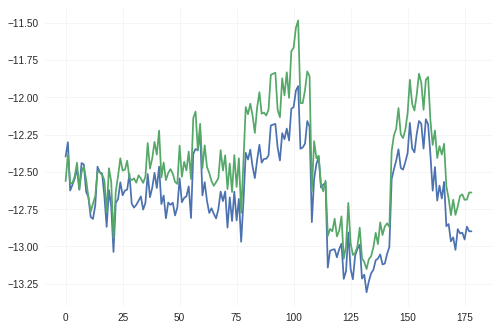

In [19]:
plot(Q1[0][:179]); hold(True); plot(Q1[1][:179])

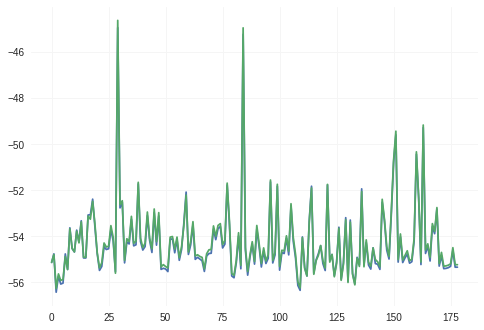

In [20]:
plot(Q[0][:179]); hold(True); plot(Q[1][:179])

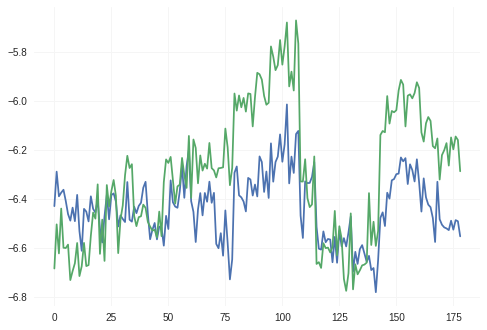

In [22]:
plot(Q[0][:179]); hold(True); plot(Q[1][:179])

In [48]:
with open("pickles/1108-treeQ.pkl",'wb') as f: 
    pickle.dump((Qest, Q, Qdist, wts, iDf, ptree), f)

In [10]:
with open("pickles/0927-nnQ.pkl",'rb') as f:
    Qest1, Q1, Qdist1, wts1, iDf1, ptree1 = pickle.load(f)
    
with open("pickles/1108-treeQ.pkl",'rb') as f:
    Qest2, Q2, Qdist2, wts2, iDf2, ptree2 = pickle.load(f)
    
# Exclude duration, intubation in policy features
features = range(24)
#features.append(33)
#wts, iDf, ptree = getImportances(Q, features)

In [47]:
wts, iDf, ptree = getImportances(Q, features)

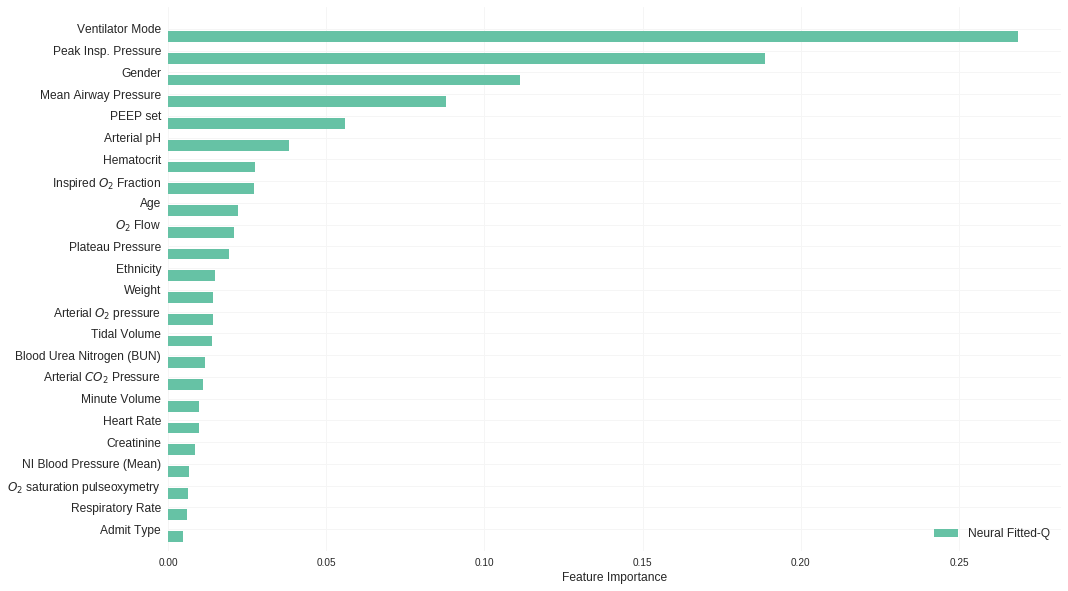

In [11]:
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

#dpoints=np.transpose(np.hstack([
#            np.vstack([['FQI w/ Extra-Trees']*len(features), [feats[x] for x in features], wts]),
#            np.vstack([['Neural Fitted-Q']*len(features), [feats[x] for x in features], wts1]) ]))

dpoints=np.transpose(np.vstack([['Neural Fitted-Q']*len(features), [feats[x] for x in features], wts2]))

def barplot(ax, dpoints):

    palette = itertools.cycle(sns.color_palette('Set2'))
    palette = itertools.cycle([sns.color_palette('Set2')[0],sns.color_palette('Set2')[4]])

    # Aggregate the conditions and the categories according to their mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(1))]
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = 0.5 # 0.3
    height = (1 - space) / n
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indices = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * height for j in indices]
        ax.barh(pos, vals, height=width, label=cond, color=next(palette))
    
    ax.set_yticks(indices)
    ax.set_yticklabels(categories, size=12)    
    ax.set_xlabel("Feature Importance",size=12)
    ax.set_ylabel("", size=12)
    ax.set_ylim([0, len(categories)+1])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='lower right',fontsize=12)
        
barplot(ax, dpoints)
plt.show()

--------------------------------------

In [13]:
ptree=ptree2
def ids(h):
    return np.concatenate(np.where(hadmsList == h))

def piHosp(h, action='vent'): 
    
    if action == 'vent':
        pi = ventActions[ids(h)]
    elif action == 'sed':
        pi = sedActions[ids(h)]
    return pi
    
def piRL(h, policyTree=ptree, features=range(24),  prob=False, action='vent'):
    
    states = [np.transpose([currStatesScaled[i][j] for j in features]) for i in ids(h)]
    if prob == True:
        pi = np.transpose(policyTree.predict_proba(states))[0]
    else:
        pi = 1 - np.transpose(policyTree.predict(states))
    return pi

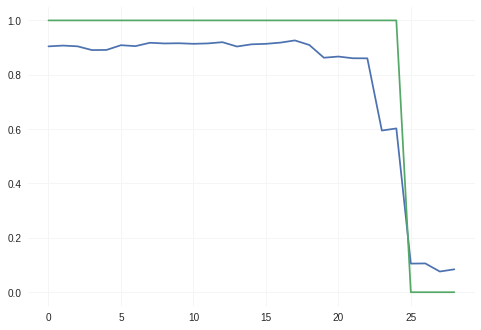

In [14]:
plot(piRL(testPts[369], ptree, features, prob=True))
plot(piHosp(testPts[369]))

In [128]:
piRL(hadms[1800], ptree, features, prob=True)[78:85]
(currStates[ids(hadms[1800])[83]]) #- currStates[np.concatenate(np.where(hadmsList == hadms[1800]))[79]])[:24]

array([ 0.68905007,  0.37455961,  0.29372403,  0.31777866,  0.28549077,
        0.28298188,  0.50916896])

In [15]:
# Evaluation:

def getFractionMatches(a, policyTree, features, tset=testPts):

    total = {}
    matches = {}
    fracMatches = []
    
    for h in tset:
        total[h] = len(piHosp(h, a))
        matches[h] = np.where(piHosp(h, a) - piRL(h, policyTree, features, a) == 0)[0]
        fracMatches.append(100 * len(matches[h])/float(total[h])) 

    return np.asarray(fracMatches)

fracMatches = getFractionMatches('vent', ptree, features)

(array([ 28.,  34.,  29.,  29.,  30.,  21.,  23.,  23.,  22.,  25.,  34.,
         30.,  23.,  25.,  21.,  22.,  30.,  38.,  22.,  21.]),
 array([   0.75757576,    5.71969697,   10.68181818,   15.64393939,
          20.60606061,   25.56818182,   30.53030303,   35.49242424,
          40.45454545,   45.41666667,   50.37878788,   55.34090909,
          60.3030303 ,   65.26515152,   70.22727273,   75.18939394,
          80.15151515,   85.11363636,   90.07575758,   95.03787879,  100.        ]),
 <a list of 20 Patch objects>)

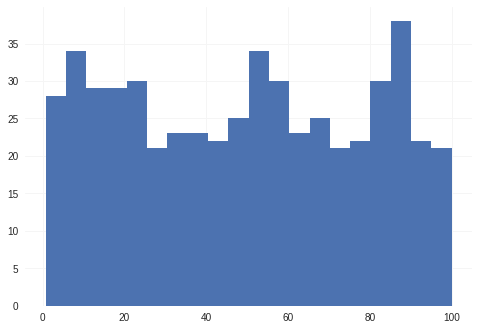

In [30]:
hist(fracMatches, 20)

In [16]:
#bins = stats.mstats.mquantiles(fracMatches, [0, 1./5, 2./5, 3./5, 4./5, 1])
bins=[100, 93, 85, 70, 55, 0]   
#bins=[100, 92, 65, 45, 30, 0]   
bins=[100, 90, 70, 50, 30, 0]   

dists = [np.where(fracMatches >= bins[0])[0]]
for i in range(len(bins)-1):
    dset = np.where(np.logical_and((fracMatches >= bins[i+1]), (fracMatches < bins[i])))[0]
    dists.append(dset)
[len(d) for d in dists]

[3, 57, 128, 116, 106, 120]

In [32]:
wts2

array([ 0.00464285,  0.01473074,  0.11137123,  0.02197886,  0.01428727,
        0.00979194,  0.00604708,  0.00634993,  0.00673991,  0.02091055,
        0.02719209,  0.01118635,  0.03807909,  0.01406784,  0.08787591,
        0.26877654,  0.18882909,  0.01933871,  0.00989964,  0.0140333 ,
        0.05598014,  0.00858652,  0.02760295,  0.01170145])

In [17]:
dists

[array([ 62, 266, 369]),
 array([  4,  12,  16,  17,  18,  27,  32,  41,  42,  70,  71,  79,  88,
        113, 117, 123, 140, 141, 144, 173, 176, 183, 201, 213, 219, 222,
        243, 251, 277, 306, 318, 334, 337, 338, 342, 349, 350, 368, 378,
        380, 388, 408, 414, 420, 437, 439, 446, 451, 458, 463, 465, 466,
        492, 509, 513, 520, 527]),
 array([  6,  10,  11,  14,  20,  22,  24,  30,  34,  38,  44,  45,  47,
         50,  51,  52,  59,  61,  63,  64,  66,  82,  85,  86,  94,  96,
         98, 102, 104, 106, 108, 109, 121, 122, 124, 126, 127, 130, 133,
        145, 147, 155, 158, 159, 160, 161, 162, 163, 167, 171, 175, 181,
        186, 189, 190, 191, 197, 200, 209, 228, 230, 256, 259, 261, 264,
        267, 269, 271, 273, 275, 278, 290, 291, 292, 298, 302, 303, 304,
        317, 321, 323, 327, 330, 331, 332, 339, 344, 345, 346, 348, 352,
        353, 358, 361, 364, 366, 374, 379, 384, 393, 399, 415, 416, 421,
        426, 429, 444, 448, 454, 455, 457, 459, 464, 467, 468, 4

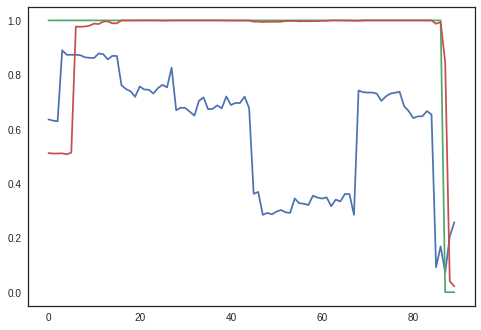

In [82]:
plot(piRL(testPts[10], prob=True))
hold(True)
plot(piHosp(testPts[10]))
states = [np.transpose([currStatesScaled[i][j] for j in range(34)]) for i in ids(testPts[10])]
plot(np.transpose(empirical_piHosp.predict(states)))
#plot([rewards[i] for i in ids(testPts[10])])

In [81]:
k = 1
states = [np.transpose([currStatesScaled[i][j] for j in range(34)]) for i in ids(testPts[k])]
sum([rewards[i] for i in ids(testPts[k])]*piRL(testPts[k], prob=True)), sum([rewards[i] for i in ids(testPts[k])]*empirical_piHosp.predict(states))

(-27.388902281886658, -84.830805320527972)

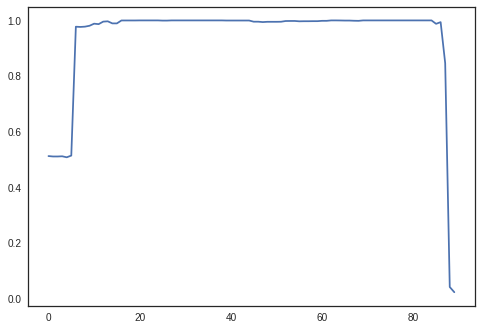

In [52]:
states = [np.transpose([currStatesScaled[i][j] for j in range(34)]) for i in ids(testPts[10])]
plot(np.transpose(empirical_piHosp.predict(states)))

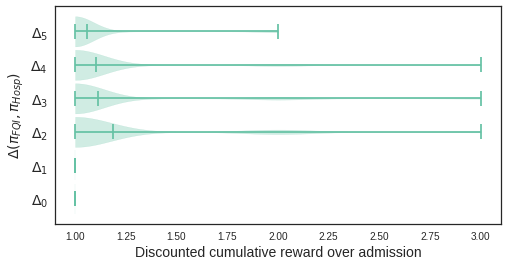

In [20]:
gamma = 0.99
discount = []

for i in range(max([len(ids(h)) for h in trainPts])):
    discount.append(gamma**i)
discount = array(discount)


finHr = {}; nd=0
for d in dists:
    finHr[nd] = [mean([rewards[r] for r in ids(hadms[i])] * array(discount[:len(ids(hadms[i]))])) for i in d]
    finHr[nd] = [max(np.transpose(currStates[ids(testPts[i])])[33]) for i in d]
    #finHr[nd] = [len([rewards[r] for r in ids(hadms[i])]) for i in d]
    nd = nd + 1

plt.style.use('seaborn-white')
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})

pos = [1, 2, 3, 4, 5, 6]
data = [finHr[i] for i in range(0,6)]
figure(figsize=(8,4))
fig = plt.subplot()
violin_parts = plt.violinplot(data, pos, vert=False, widths=0.9, showmeans=True, showextrema=True, showmedians=False)
fig.set_yticklabels(['','$\Delta_0$','$\Delta_1$','$\Delta_2$','$\Delta_3$','$\Delta_4$','$\Delta_5$'], size=14)
fig.set_xlabel('# Intubations over admission', size=14)
fig.set_xlabel('Discounted cumulative reward over admission', size=14)
fig.set_ylabel('$\Delta(\pi_{FQI}, \pi_{Hosp})$', size=14)

colour0 = sns.color_palette('Set2')[0]
colour1 = sns.color_palette('Set2')[1]

for pc in violin_parts['bodies']: pc.set_facecolor(colour0); pc.set_edgecolor(colour0)
for pc in ['cmeans', 'cmins', 'cmaxes', 'cbars']: violin_parts[pc].set_color(colour0)
plt.show()

In [ ]:
finHr[0]

In [144]:
[max(np.transpose(currStates[ids(testPts[i])])[33]) for i in d]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [39]:
empirical_piHosp.predict()

(ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False))

In [184]:
np.unique([max(np.transpose(currStates[ids(hadms[i])])[33]) for i in range(len(hadms))], return_counts=True)

(array([ 1.,  2.,  3.,  4.]), array([1857,  152,   20,    1]))

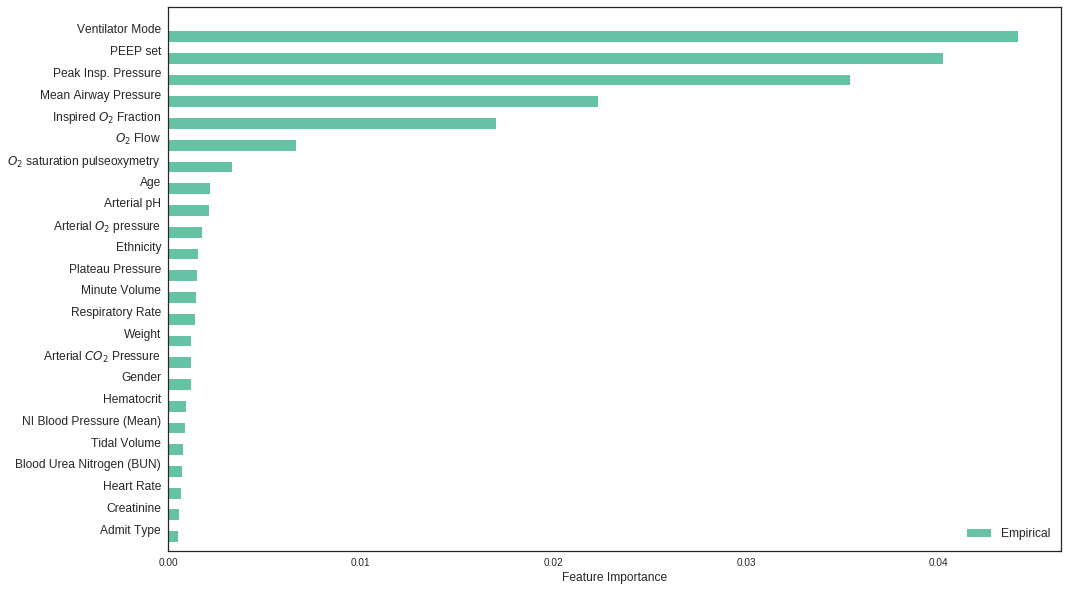

In [37]:
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf

#empirical_piHosp = fitTree(trainStates, trainActions)

fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

dpoints=np.transpose(np.vstack([['Empirical']*len(features), [feats[x] for x in features], [empirical_piHosp.feature_importances_[x] for x in features]]))
barplot(ax, dpoints)
plt.show()

---------------------------------------------

In [64]:
res = (np.where([max(np.transpose(currStates[ids(hadms[i])])[33]) > 1 for i in range(len(hadms))])[0])

Text(0.5,0,u'Days between reintubations')

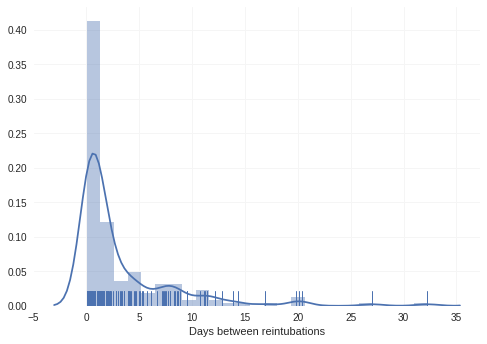

In [111]:
sns.distplot([sum(np.trim_zeros(np.transpose(currStates[ids(hadms[res[i]])])[32]) == 0)/24.0 for i in range(len(res))], rug=True)
xlabel('Days between reintubations')